# Unet workflow

> Example workflow for training a semantic segmentation model with `fastai`

In [ ]:
import rasterio as rio
import geopandas as gpd
from pathlib import Path
import rasterio.plot as rioplot
import matplotlib.pyplot as plt

In [ ]:
path_to_data = Path('workflow_examples/')
train_raster = path_to_data/'104_28_Hiidenportti_Chunk1_orto.tif'
train_shp = path_to_data/'104_28_Hiidenportti_Chunk1_orto.geojson'
test_raster = path_to_data/'104_42_Hiidenportti_Chunk5_orto.tif'
test_shp = path_to_data/'104_42_Hiidenportti_Chunk5_orto.geojson'

Example data is RGB UAV imagery from Hiidenportti, and the task is to detect and segment different deadwood types. The reference data are annotated as polygons, and target column is `layer`.

Training area looks like this.

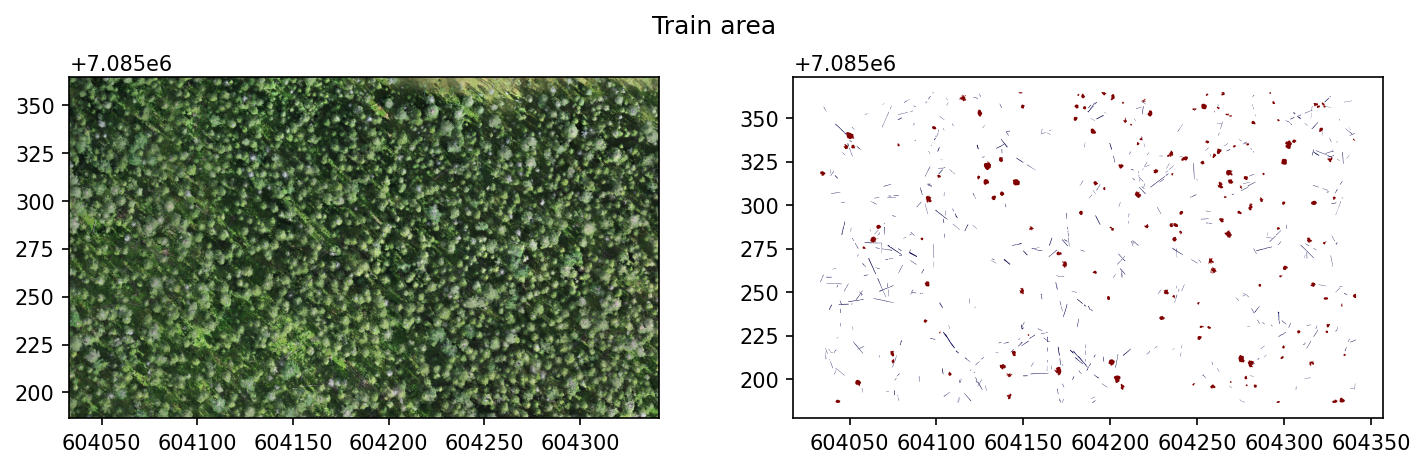

In [ ]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,3))
with rio.open(train_raster) as src:
    rioplot.show(src, ax=axs[0])
train_gdf = gpd.read_file(train_shp)
train_gdf.plot(column='layer', ax=axs[1], cmap='seismic')
plt.suptitle('Train area')
plt.tight_layout()
plt.show()

And test area looks like this.

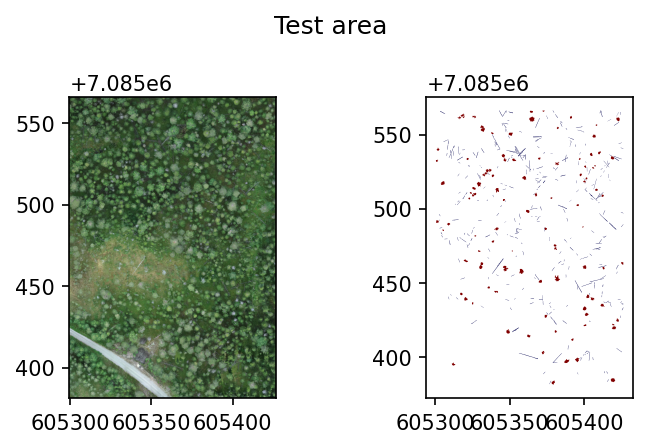

In [ ]:
fig, axs = plt.subplots(1,2, dpi=150, figsize=(5,3))
with rio.open(test_raster) as src:
    rioplot.show(src, ax=axs[0])
test_gdf = gpd.read_file(test_shp)
test_gdf.plot(column='layer', ax=axs[1], cmap='seismic')
plt.suptitle('Test area')
plt.tight_layout()
plt.show()

## Install required dependencies

Simplest way to install `fastai` is 

```bash
conda install -c fastchan fastai
```

Other ways to install can be found [here](https://github.com/fastai/fastai).

## Create a raster dataset

In this example, the data are split into 224x224 pixel tiles with no overlap.

## CLI

```bash
geo2ml_create_raster_dataset \
example_data/workflow_examples/104_28_Hiidenportti_Chunk1_orto.tif \
example_data/workflow_examples/104_28_Hiidenportti_Chunk1_orto.geojson \
example_data/workflow_examples/unet/train \
--target_column layer --gridsize_x 224 --gridsize_y 224

geo2ml_create_raster_dataset \
example_data/workflow_examples/104_42_Hiidenportti_Chunk5_orto.tif \
example_data/workflow_examples/104_42_Hiidenportti_Chunk5_orto.geojson layer \
example_data/workflow_examples/unet/test \
--target_column layer --gridsize_x 224 --gridsize_y 224
```

## Python

In [ ]:
from geo2ml.scripts.data import create_raster_dataset

In [ ]:
outpath = path_to_data/'unet'

create_raster_dataset(raster_path=train_raster, mask_path=train_shp, outpath=outpath/'train',
                      save_grid=False, target_column='layer', gridsize_x=224, gridsize_y=224)

create_raster_dataset(raster_path=test_raster, mask_path=test_shp, outpath=outpath/'test',
                      save_grid=False, target_column='layer', gridsize_x=224, gridsize_y=224)

0it [00:00, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

## Dataset structure

Above creates the dataset to `path_to_data/'unet'`, so that it contains folders `train` and `test`. Both of these contain

* folder `images`, which contains the tiled raster patches
* folder `mask_images`, which contain the rasterized masks corresponding to files in `images`
* `label_map.txt`, which has the mapping between integer values and classes

## Train the model

In [ ]:
from fastai.vision.all import *

In [ ]:
fnames = [Path(outpath/'train/images'/f) for f in os.listdir(outpath/'train/mask_images')]

def label_from_different_folder(fn, original_folder, new_folder):
    return str(fn).replace(original_folder, new_folder)

dls = SegmentationDataLoaders.from_label_func(outpath/'train/images', bs=8,
                                              codes=['Background', 'Standing', 'Fallen'],
                                              fnames=fnames,
                                              label_func=partial(label_from_different_folder,
                                                                 original_folder='images',
                                                                 new_folder='mask_images'),
                                              batch_tfms = [
                                                  *aug_transforms(max_rotate=0., max_warp=0.),
                                                  Normalize.from_stats(*imagenet_stats)
                                              ])

Fine-tune a Unet that uses resnet34 as the encoder.

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

/home/mayrajeo/miniconda3/envs/point-eo-dev/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mayrajeo/miniconda3/envs/point-eo-dev/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/mayrajeo/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████████████████████████████| 83.3M/83.3M [00:35<00:00, 2.48MB/s]


epoch,train_loss,valid_loss,time
0,0.102724,0.063255,00:31


epoch,train_loss,valid_loss,time
0,0.060898,0.049642,00:32
1,0.049917,0.035729,00:32
2,0.038387,0.032115,00:32
3,0.030265,0.028458,00:32
4,0.025367,0.025913,00:32
5,0.022732,0.025986,00:32


See the results.

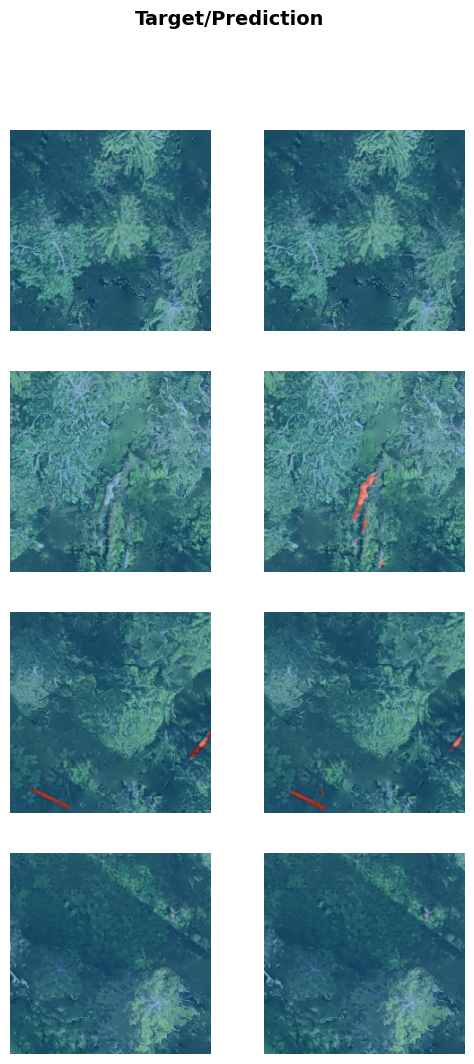

In [ ]:
learn.show_results(max_n=4)